抠图技法 | 看我用 K-Means 聚类算法从头实现图像语义分割

> 关键词：机器学习 / 无监督 / 聚类
>
> K-Means 聚类算法也可以转眼成为一个 P 图小工具，其实，这只需要一个观念的转变！

在众多聚类算法中，K-Means 算得上是其中一个经典的算法之一了，它属于无监督学习成员的一份子，训练并分类数据的过程中，不需要标签的辅助就能够掌握每一比数据之间的潜在关系，而这个关系则是通过两个点之间的距离远近来判定，离得远的表示关系小，离得近的表示关系大，他的数学表达式：

$$
\begin{aligned}
\mathcal{f}(x) = \cdots
\end{aligned}
$$

是不是没看清数学是什么呢？你没看错，因为小编这次的介绍将不从数学的角度出发推导 K-Means 的有效性，也不去证明算法的收敛性！相反地，这期小编将通过图片数据来让看官们直观感受算法的效果，同时也通过每次处理出来的图片效果来证明复杂数学说半天才能严谨解释的理论！目标说完后，先上效果图：

![kmeans_thu.jpg](pics/kmeans_thu.jpg)

原先一张色彩丰富的图片，里面相似的颜色就这么被聚类成了几个代表色块！其实要做到这个效果很简单，我们无需关注图片里到底是什么物体，只需要管图片原本总共有几个颜色，而图片在计算机里其实就是一个装满着从0到255范围数字的矩阵，如果是黑白图片，那么这个矩阵就是二维，如果是彩色，矩阵则是三维的，之所以是三维的原因在于，光的原色只有三种，分别是红蓝绿，英文缩写又叫做 RGB，通过控制这三种颜色的强弱，任何可见光的颜色就可以被混合叠加出来，进而达到彩色的视觉效果。

# 算法步骤
如果我们能首先读取图片，把一张图片的所有颜色都找出来，并且我们把每一个颜色背后所代表的内涵三个数字的向量看作是一个坐标，那么 K-Means 聚类就可以很直观的将距离相近的颜色归纳在一起，实现块状颜色图片的效果。既然这里不用数学去解释 K-Means 算法的运行机制和目标，小编就用最简单直白的陈述去解释每一个步骤的意图！

为了简化可视化的过程，这里就用经典的 `Iris 数据集` 来可视化接下来要讲的步骤。
>订阅公众号，获取代码和数据链接！订阅公众号，我们将为获取代码和数据链接！

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import datasets

接下来载入数据，这里小编已经佛心为大家找到了最适合用来做 K-Means 聚类的两个特征的数据。

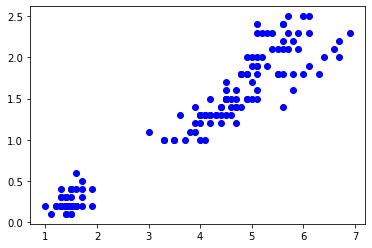

In [2]:
iris = datasets.load_iris()
plt.scatter(iris.data[:, 2],
            iris.data[:, 3],
            c='blue')
plt.show()

大体算法步骤如下：
>1. 初始化 K 个点
>2. 计算所有数据与这 K 个点之间的距离
>3. 找出每一个数据点离这 K 个初始点的距离哪个最近
>4. 把相同最近点的数据归为同一个类别
>5. 根据归到同一个类的所有点计算他们的平均
>6. 以这 K 个平均点作为新的初始点重复 2~5 个步骤直到点不再被更新

# 步骤1. 起手式 - 点初始化
K-Means 顾名思义指的是 K 个均值的意思，而到底有几个均值呢？这必须是作为一个超参数，是使用者在启动算法前就要事先定义好的一个参数，而且这个参数必须只能是整数，接下来算法要做的第一步，就是在样本空间（代表颜色的三维向量）里面去找出 K 个向量出来作为算法的迭代起点。找起点的动作特别重要，原因就在于 K-Means 算法并不是一个能够通过迭代就找到全局最优解，相反地，他只能找到局部最优，也就是说，起点的设置需要特别小心，甚至需要一些额外的小技巧去优化这些点的选择过程，否则的话 K-Means 算法很容易收敛到一个尴尬的位置。

由于数据没有标签，选初始点最好的策略就是闭着眼睛随机选，而且是加了两个小技巧的情况下闭着眼睛随机选：
1. 初始点彼此之间的距离
2. 从空间里随机生成 or 从数据集里找点

从数据集里随机找点的好处有两个，一个是我们将不容易迷失在坐标空间里，导致选到一些与数据分布偏离的位置，其二，经过算法的分类，每一比数据终将被归纳到某一个类里，如果选择了数据点以外的其他点，将大幅提升踩到类别间中线的位置，导致迭代过程没办法继续。接下来就剩下距离的考量因素，可以通过代码简单对比一下因素的有无对初始化的影响。

## 1-1. 真·随机初始化
如果不考虑距离在里面，那随机选点的过程很简单，函数定义如下：

In [3]:
def init_random(dataset, k):
    # 确保没有重复的数据
    dataset = np.unique(dataset, axis=0)
    
    # 创建所有数据的索引与承接初始点的容器
    records = np.zeros([k, dataset.shape[1]])
    indices = np.arange(dataset.shape[0])
    selected = []
    
    for i in range(k):
        # 如果是第一次找初始点 ...
        if i == 0:
            # ... 随机找一个数据点
            idx = np.random.choice(indices)
            # 并保存该点到矩阵中
            records[i] = dataset[idx]
            # 然后标记点的索引
            selected.append(idx)
        else:
            # 如果不是第一次找点，得删除之前找过的点避免重复
            idx = np.random.choice(np.delete(indices, selected))
            # 保存找到的新点到矩阵中
            records[i] = dataset[idx]
            # 然后记录点的索引
            selected.append(idx)

    return records

然后就可以看看初始点的分布状态：

In [4]:
pts = init_random(iris.data[:, 2:], k=3)
print(pts)

[[4.  1.2]
 [6.7 2. ]
 [1.5 0.1]]


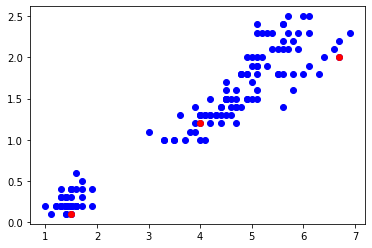

In [5]:
plt.scatter(iris.data[:, 2],
            iris.data[:, 3],
            c='blue')
plt.scatter(pts[:, 0], pts[:, 1],
            c='red')
plt.show()

由于没有对点之间的距离做约束，它们就很有可能离得很近，导致后面迭代的过程遇到不可预期的阻碍，这也是本篇文章不断强调的，初始化非常重要，需要一些小技巧去优化，而距离约束可以说是最有效的技巧，没有之一！

## 1-2. 距离约束·初始化
为了计算距离，我们首先就要定义距离的公式，二维空间很简单，用毕式定理就可以算出两点距离，如果遇到更高维度的数据，公式其实也很类似，只是变量多了点。

$$
\begin{aligned}
\sqrt{x^2 + y^2 + \cdots}
\end{aligned}
$$

有几个维度就多几个变量的平方相加，接下来我们得去计算所有初始点到所有数据点的个别距离，也就是说，我们需要计算 `K x #Data` 个距离。

In [6]:
def euclidean(inits, pts):
    # 创建一个空的矩阵准备记录每一个距离
    rec = np.zeros([inits.shape[0],
                    pts.shape[0]])
    # 遍历所有初始点计算个别的距离
    for i, init in enumerate(inits):
        dists = np.square(init - pts)
        dists = np.sqrt(np.sum(dists, axis=1))
        rec[i] = dists

    return rec

加上距离约束之后要选择点的话过程就比较麻烦了，每一次的选取操作必须独立执行，执行前还得重复检查是否距离够远，所以选点的过程就得通过迭代来完成。

In [7]:
def init_kmeans(dataset, k, distance=0.01):
    # 确保没有重复的数据
    dataset = np.unique(dataset, axis=0)
    # 创建一个矩阵容器准备记录选中的初始点
    records = np.zeros([k, dataset.shape[1]])
    # 设定最远的 n 个点作为随机选取的点
    threshold = int(dataset.shape[0] * (1 - distance))
   
    # 迭代选取 K 个初始点
    for i in range(k):
        # 如果选的是第一个点 ...
        if i == 0:
            # ... 那么就随机选取
            idx = np.random.choice(dataset.shape[0])
            # 并把点存入容器里
            records[i] = dataset[idx]
           
        # 如果选的不是第一个点了 ...
        else:
            # 那么得先量一下目前已经选中的点与其他所有数据点的距离
            alldists = euclidean(records[:i], dataset)
            # 选出那些离选中点最远的几个点来随机选取
            indices = np.argsort(alldists, axis=1)[:, -threshold:]
            # 数一数数据点和几个初始点保持了足够的距离
            indices, cnt = np.unique(indices, return_counts=True)
            # 只选择那些和所有已选中的初始点都保持足够距离的点作为随机选择的点
            selected = dataset[indices[cnt==i]]
           
            # 随机选择某一个点到一个矩阵中
            idx = np.random.choice(selected.shape[0])
            records[i] = selected[idx]
           
    return records

函数构建完了，启动它看效果！

In [8]:
pts = init_kmeans(
    iris.data[:, 2:], k=3,
    distance=0.5)
print(pts)

[[1.3 0.2]
 [5.3 2.3]
 [6.6 2.1]]


然后就可以看看初始点的分布状态：

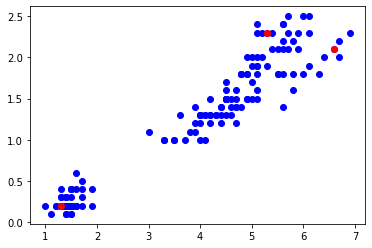

In [9]:
plt.scatter(iris.data[:, 2],
            iris.data[:, 3],
            c='blue')
plt.scatter(pts[:, 0], pts[:, 1],
            c='red')
plt.show()

对比之前没有距离约束的初始化，在都是随机选择的情况下，明显这个效果好得多！接着就能开始通过上面列举的步骤 2~5 迭代更新这些初始点了。

# 步骤2~5. 参数更新
回顾一下这些步骤的细节：
>2. 计算所有数据与这 K 个点之间的距离
>3. 找出每一个数据点离这 K 个初始点的距离哪个最近
>4. 把相同最近点的数据归为同一个类别
>5. 根据归到同一个类的所有点计算他们的平均

所有操作都能够通过上面定义的函数完成，因此下面直接从头构建 K-Means:

In [10]:
def kmeans(dataset, k, init_method=init_random):
    # 初始化 K 个点作为开始迭代的点
    init_points = init_method(dataset, k)
   
    # 开始迭代直到点不再更新
    i = 0
    while True:
        # 步骤2. 计算距离
        dists = euclidean(init_points, dataset)
        # 步骤3. 找出最近的点
        clss = np.argmin(dists, axis=0)
       
        Z = 0
        for n, point in enumerate(init_points):
            # 步骤4~5. 归类并计算均值
            update_point = dataset[clss==n].mean(axis=0)
           
            # 如果新的点不等于以前的点 ...
            if np.sum(update_point == point) == 0:
                # ... 则更新这个点
                init_points[n] = update_point
            else:
                # 如果其中已经有点不用更新就 +1
                Z += 1
                continue
               
        # 如果所有点都不再更新则停止迭代
        if Z == init_points.shape[0]:
            break
           
    return init_points

In [11]:
results = kmeans(
    iris.data[:, 2:], k=3,
    init_method=init_kmeans)
print(results)

[[5.59583333 2.0375    ]
 [4.26923077 1.34230769]
 [1.462      0.246     ]]


最后画个图看一下迭代完成的数据被分类后的效果。

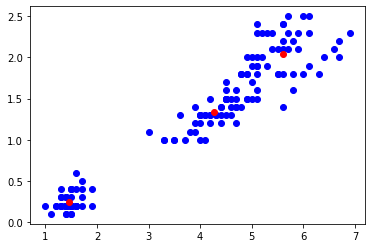

In [12]:
plt.scatter(iris.data[:, 2],
            iris.data[:, 3],
            c='blue')
plt.scatter(results[:, 0], results[:, 1],
            c='red')
plt.show()

# K-Means 结果评估
不过，就如同小编最易开始的时候所说，K-Means 算法不能找到最优解，相反地，它的结果好坏非常依赖初始化的位置，因此为了确保模型的稳定性，最好的办法就是多运行几次，所以还有最后一个函数需要构建，不过由于代码有点，如果屏幕前的你都已经看到这里，那不妨订阅本公众号并找到GitHub，完整代码将在那里等待你的查看！

In [13]:
def evaluate(dataset, k, max_iter=100, init_method=init_random):
    # 生成一些列表预备用来保存初始点和结果好坏
    total_centroids = []
    total_costs = []
    
    desc = '\n[+] K-Means - get {} clusters'.format(k)
    
    # 运行 K-Means 多次找出最好的一次
    for i in tqdm(range(max_iter), desc=desc, total=max_iter, unit=' times'):
        # K-Means 算法的核心机制
        centroids = kmeans(dataset, k, init_method=init_method)
        dists = euclidean(centroids, dataset)
        clss = np.argmin(dists, axis=0)
        
        cost_val = 0
        for j, centroid in enumerate(centroids):
            # 找出每笔数据对应类别的中心点的距离并全加起来
            cost_val += np.sum(dists[:, clss==j][j])
            
        # 记录中心点信息和距离的累加
        total_centroids.append(centroids)
        total_costs.append(cost_val)
    
    # 用最短总距离的那个结果作为最终的结果
    k_points = np.array(total_centroids[np.argmin(total_costs)])
    
    final_dists = euclidean(k_points, dataset)
    final_clss = np.argmin(final_dists, axis=0)
    return final_clss, k_points

In [14]:
classes, k_pts = evaluate(
    iris.data[:, 2:],
    k=3, max_iter=100,
    init_method=init_random)


[+] K-Means - get 3 clusters: 100%|██████████| 100/100 [00:00<00:00, 622.19 times/s]


这个函数目标就是运行 K-Means 算法 `max_iter` 次，并找出结果最好的那个作为最终结果，并给出每一比数据对应的类别，可视化呈现如下：

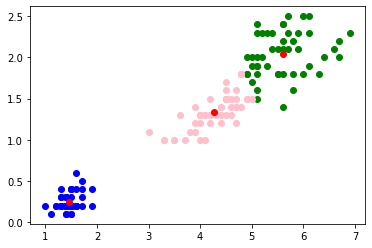

In [15]:
plt.scatter(iris.data[:, 2][classes==0],
            iris.data[:, 3][classes==0], c='blue')
plt.scatter(iris.data[:, 2][classes==1],
            iris.data[:, 3][classes==1], c='green')
plt.scatter(iris.data[:, 2][classes==2],
            iris.data[:, 3][classes==2], c='pink')
plt.scatter(k_pts[:, 0], k_pts[:, 1], color='red')
plt.show()

# 图片语义分割
了解了算法的整个原理了之后，终于能够把前面的所学与实践用到图片上，什么图片都适合，只是为了读取图片，我们需要新的模块来帮我们完成这件事。

In [16]:
from PIL import Image

同时为了打印出图片被处理过后的效果，小编这里也一起把可视化代码封装到了下面的函数里！

In [17]:
def transform(image, k):
    # 读取图片并确保他只有三通道
    img = Image.open(image).convert('RGB')
    # 获取图片宽高信息
    W, H = img.size
   
    # 创建图表并定义尺寸以供后面可视化呈现
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(2, 2, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    # 先画上第一张没经过处理的图
    ax.imshow(np.array(img))
   
    # 遍历所有定义好的 K 值
    for p, n in enumerate(k):
        # 将所有像素格转换成二维矩阵
        arr = np.array(img).reshape(-1, 3)
        # 使用 K-Means 完成计算
        color_cls, k_colors = evaluate(arr, n, max_iter=5,
                                       init_method=init_random)
        k_colors = np.round(k_colors).astype(np.uint8)

        # 用计算的均值颜色去替换同类的颜色
        arr_t = k_colors[color_cls].reshape(H, W, 3)
       
        # 把三维矩阵重新放回 Image 类里面
        transform = Image.fromarray(arr_t.astype(np.uint8), 'RGB')
        # 并通过类的方法保存图片
        transform.save(os.path.join('./', 'trans{}.jpg'.format(n)))
   
        # 同时把处理的图片贴到图表中的指定位置
        ax = fig.add_subplot(2, 2, p+2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(arr_t)
       
    # 最终打印图片
    plt.show()


[+] K-Means - get 8 clusters: 100%|██████████| 5/5 [00:27<00:00,  5.49s/ times]

[+] K-Means - get 5 clusters: 100%|██████████| 5/5 [00:10<00:00,  2.07s/ times]

[+] K-Means - get 3 clusters: 100%|██████████| 5/5 [00:10<00:00,  2.01s/ times]


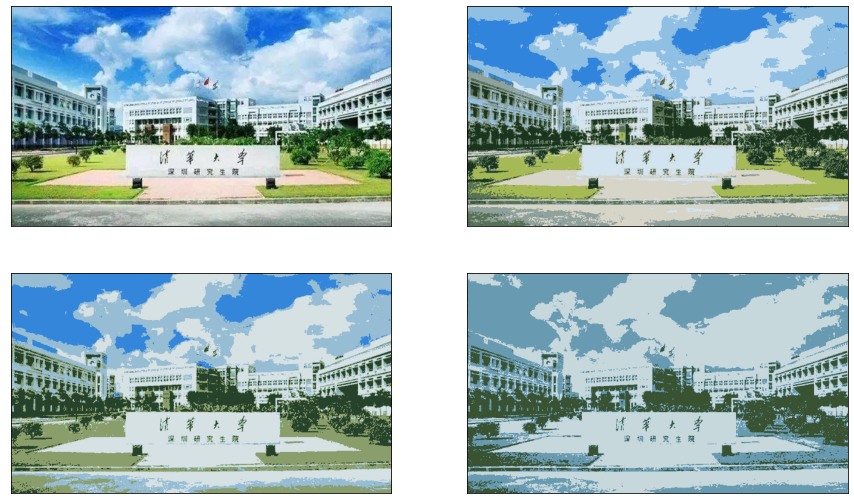

In [18]:
transform('campus.jpg', k=[8, 5, 3])

# scikit-learn
当然如果只是纯粹想拿这个算法玩玩，觉得从头实现实在太麻烦，最快的方法就是调用现成的 API 即可，而 sklearn 正好提供了这个算法的类给大家使用。

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,
                max_iter=100,
                init='k-means++')
kmeans.fit(iris.data[:, 2:])

KMeans(max_iter=100, n_clusters=3)

In [20]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

不过！小编忍不住做了下对比，发现其实上面自己构建的算法速度，并没比 API 提供的函数效率低，证明了在 K-Means 算法上我们的复现水平已经趋近于 sklearn 团队的能力，欢迎试跑我们的代码，并在下方留言你对比的结果！